In [67]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn.functional as F
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

This notebook is a simple implementation of the REINFORCE algorithm. REINFORCE is a basic policy gradient algorithm which is on-policy, and the objective function is the average one-step reward:

\begin{equation}
\begin{aligned}
J &\doteq\mathbb{E}_{S}\left[r_\pi(S)\right] = \mathbb{E}_{\tau \sim \pi_{\theta}}\left[R(\tau)\right] \\
& = \lim _{n \rightarrow \infty} \frac{1}{n} \mathbb{E}\left[\sum_{k=1}^n R_{t+k}\right]
\end{aligned}
\end{equation}

Our goal is to solve an optimization problem to maximize the objective function $J$ and obtain the optimal policy $\pi^*$. Here, the policy will be a parameterized function $\pi(a \mid s, \theta)$, where $\theta$ is the parameter of the policy function. The gradient of the objective function can be **approximated** as:

\begin{equation}
\begin{aligned}
\nabla_\theta J &\approx \mathbb{E}_{S,A} \left[\nabla_\theta \ln \pi(A \mid S, \theta) \cdot q_\pi(S, A)\right] \\
& = \frac{1}{N}\sum\limits_{t = 0}^N { \nabla_\theta \ln \pi(a_t \mid s_t, \theta) \cdot q_\pi(s_t, a_t) } 
\end{aligned}
\end{equation}
As the discount $\gamma$ approaches 1, the approximation becomes more accurate. When $\gamma=1$, both sides of the equation are equal.

One can use the sothastic gradient ascent to update the policy parameter $\theta$:

\begin{equation}
\theta \gets \theta +\alpha \cdot \sum\limits_{t = 0}^N \nabla_{\theta} \ln \pi\left(a_t \mid s_t, \theta\right) \cdot q_{\pi}\left(s_t, a_t\right)
\end{equation}
where $\frac{1}{N}$ can be absorbed into the learning rate $\alpha$.

The above procedure constructs the *"main loop"* of classical policy gradient algorithms. From the structure of the equation, we can treat the term after the learning rate as the **approximated** objective function of the optimization problem. Such objective function is actually the *loss function* for training the policy network. Therefore, the policy network can be trained by **maximize** the loss function:

\begin{equation}
loss = \sum\limits_{t = 0}^N \ln \pi\left(a_t \mid s_t, \theta\right) q_{\pi}\left(s_t, a_t\right)
\end{equation}

Again, we should remember the "policy training" is actually solving an optimization problem but not to approximate something. Interestingly, we can use any nonlinear solver to solve the problem such as *IPOPT*, *SNOPT* and even *heuristics* such as genetic algorithm. However, the most common method in RL is to use the gradient descent method. In this notebook, we will continue to use feature of automatic differentiation in PyTorch to calculate the gradient of the loss function and update the policy network.

Now the question is how to calculate the current action value $q_{\pi}(s_t,a_t)$. Similar to the MC Algorithm, REINFORCE directly uses the sampled return $G_t$ to approximate the action value $q_{\pi}(s_t,a_t)$ and then "solve" the optimization problem after finishing an episode.

\begin{equation}
\begin{aligned}
q_t(s_t,a_t) &= \mathbb{E} \left[G_t \mid S_t=s_t, A_t=a_t\right] 
& \approx G_t
& = \sum_{k=t+1}^N \gamma^{k-t-1} r_k  ~~~~ \text{[MC: episode-by-episode fashion]}
\end{aligned}
\end{equation}

Then the new loss of REINFORCE can be written as:

\begin{equation}
loss = \sum\limits_{t = 0}^N \left( \ln \pi\left(a_t \mid s_t, \theta\right) \cdot \sum_{k=t+1}^N \gamma^{k-t-1} r_k \right)
\end{equation}

In [68]:

class REINFORCE_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    
    def __init__(self,
                 episode_recorder:object, # The episode recorder
                 policy_network:torch.nn, # The policy network
                 optimizer:torch.optim, 
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.policy_network = policy_network
        self.episode_recorder = episode_recorder
        self.optimizer = optimizer
        
        self.gamma = gamma
            
    def get_action(self, obs:np.ndarray) -> int:
        """ The output of policy network is the action distribution. We need to sample an action from it. """
        
        obs = torch.tensor(obs, dtype = torch.float32).to(self.device)
        dist = self.policy_network(obs) # NN_outputs -softmax-> Action distribution
        dist = F.softmax(dist, dim = 0) 
        action_probs = torch.distributions.Categorical(dist)
        picked_action = action_probs.sample()
               
        return picked_action.item()
    
    def calculate_log_prob(self, obs:torch.tensor, action:torch.tensor) -> torch.tensor:
        """ Calculate the log probability of the picked action. """
        dist = F.softmax(self.policy_network(obs), dim=1)
        log_prob = torch.log(dist.gather(1, action))
        
        return log_prob
    
    def calculate_discounted_return(self, reward:torch.tensor) -> torch.tensor:
        """G_t = R_{t+1} + \gamma * R_{t+2} + \gamma^2 * R_{t+3} + ... + \gamma^{T-t-1} * R_{T} """
        
        length = len(reward)
        G = torch.zeros_like(reward)
        for i in range(length):
            G[i] = sum([reward[j] * self.gamma ** j for j in range(i, length)])

        return G
    
    def train_policy(self) -> None:
        """ Train the policy network with the trajectory of one episode. """
        
        obs, action, reward = self.episode_recorder.get_trajectory()
        log_prob = self.calculate_log_prob(obs,action)
        G = self.calculate_discounted_return(reward)
        
        loss = torch.sum(-log_prob * G) # loss = sum_t (-log_prob_t * G_t)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        

In [69]:
class Policy_Network(torch.nn.Module):
    """Softmax layer is not included in the network to avoid the gradient explosion in NN.
       The softmax operation is included in the get_action function."""
      
    def __init__(self,obs_dim:int,action_dim:int) -> None:
        super(Policy_Network, self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
                    
    def forward(self,x:torch.tensor) -> torch.tensor:
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
class Episode_Recorder():
    """ Record the trajectory of each step in one episode using dictionary."""
    
    def __init__(self, device:torch.device = torch.device("cpu")) -> None:
        self.device = device
        self.reset()
        
    def append(self, 
               obs: np.ndarray,
               action: int,
               reward:float) -> None:
        
        obs = torch.tensor(np.array([obs]), 
                           dtype = torch.float32).to(self.device)
        action = torch.tensor(np.array([[action]]), 
                              dtype = torch.int64).to(self.device)
        reward = torch.tensor(np.array([[reward]]), 
                              dtype = torch.float32).to(self.device)
        
        self.trajectory["obs"] = torch.cat((self.trajectory["obs"], obs))
        self.trajectory["action"] = torch.cat((self.trajectory["action"], action))
        self.trajectory["reward"] = torch.cat((self.trajectory["reward"], reward))
        
    def get_trajectory(self) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        """Return the trajectory in the form of tensors"""
        
        return self.trajectory["obs"], self.trajectory["action"], self.trajectory["reward"]
    
    def reset(self) -> None:
        """ Clear the trajectory when begin a new episode."""
        self.trajectory = {
            "obs": torch.tensor([], dtype = torch.float32).to(self.device),
            "action": torch.tensor([], dtype = torch.int64).to(self.device),
            "reward": torch.tensor([], dtype = torch.float32).to(self.device),
        }

In [71]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9,
                 seed = 0,
                 my_device = "cpu"
                 ) -> None:
        
        self.seed = seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device(my_device)
    
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        episode_recorder = Episode_Recorder(device = self.device)
        policy_network = Policy_Network(obs_dim,action_dim).to(self.device)
        optimizer = torch.optim.Adam(policy_network.parameters(),lr=lr)
        self.agent = REINFORCE_Agent(policy_network = policy_network,
                               episode_recorder = episode_recorder,
                               optimizer = optimizer,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(self.episode_num)
        self.index_episode = 0    
        
    def train_episode(self) -> float:
        total_reward = 0
        self.agent.episode_recorder.reset() 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.agent.episode_recorder.append(obs,action,reward)
            total_reward += reward 
            obs = next_obs                
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        self.agent.train_policy()
            
        return total_reward  
        
    def train(self) -> None:      
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
                        
    def plotting(self,smoothing_window:int = 100) -> None:
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

Episode 0: Total Reward = 22.00
Episode 100: Total Reward = 66.00
Episode 200: Total Reward = 120.00
Episode 300: Total Reward = 84.00
Episode 400: Total Reward = 62.00
Episode 500: Total Reward = 138.00
Episode 600: Total Reward = 124.00
Episode 700: Total Reward = 125.00
Episode 800: Total Reward = 106.00
Episode 900: Total Reward = 189.00


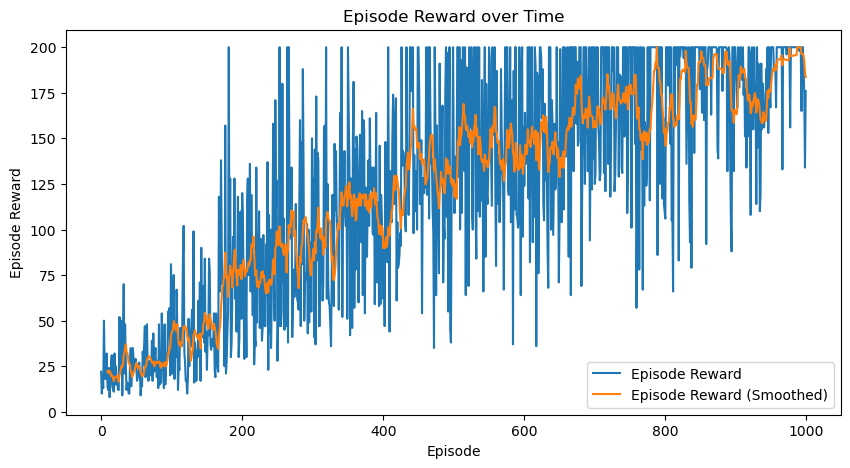

In [72]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 1e-3,
                        gamma = 0.98,
                        seed = 0,
                        my_device = "cpu"
                        )
    Manger.train()
    Manger.plotting(smoothing_window=10)